<a href="https://colab.research.google.com/github/Nithesh-b/config/blob/master/Mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import keras
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import argparse
from google.colab.patches import cv2_imshow
from natsort import natsorted, ns 

In [3]:
def data_summary(main_path):
    withmask_path = main_path+'masked'
    withoutmask_path = main_path+'unmasked'
    # number of (images) that are in the the folder named 'masked' 
    m_pos = len(listdir('/content/drive/My Drive/dataset/train_validate/masked')) 
    # number of (images) that are in the the folder named 'without_mask' 
    m_neg = len(listdir('/content/drive/My Drive/dataset/train_validate/unmasked'))
    # number of all examples
    m = (m_pos+m_neg)
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}")    
augmented_data_path = '/content/drive/My Drive/dataset/train_validate'    
data_summary(augmented_data_path)

Number of examples: 1727
Percentage of positive examples: 51.36074116965837%, number of pos examples: 887
Percentage of negative examples: 48.63925883034163%, number of neg examples: 840


In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', 
    input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [5]:
TRAINING_DIR = "/content/drive/My Drive/dataset/train_validate"
train_datagen = ImageDataGenerator(rescale=1.0/255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR, batch_size=10, target_size=(64, 64))
VALIDATION_DIR = "/content/drive/My Drive/dataset/test"
validation_datagen = ImageDataGenerator(rescale=1.0/255) 
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, batch_size=10, target_size=(64, 64))
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

Found 1727 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


In [6]:
history = model.fit(train_generator,epochs=30,validation_data=validation_generator,callbacks=[checkpoint])
model.save('covid_model_facemask.h5')

Epoch 1/70
173/173 [==============================] - ETA: 0s - loss: 0.4547 - acc: 0.7881WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model-001.model/assets
173/173 [==============================] - 1259s 7s/step - loss: 0.4547 - acc: 0.7881 - val_loss: 0.3892 - val_acc: 0.8625
Epoch 2/70
173/173 [==============================] - 19s 112ms/step - loss: 0.2736 - acc: 0.8946 - val_loss: 0.4827 - val_acc: 0.8219
Epoch 3/70
173/173 [==============================] - 19s 109ms/step - loss: 0.2771 - acc: 0.8859 - val_loss: 0.3930 - val

[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] computing face detections...


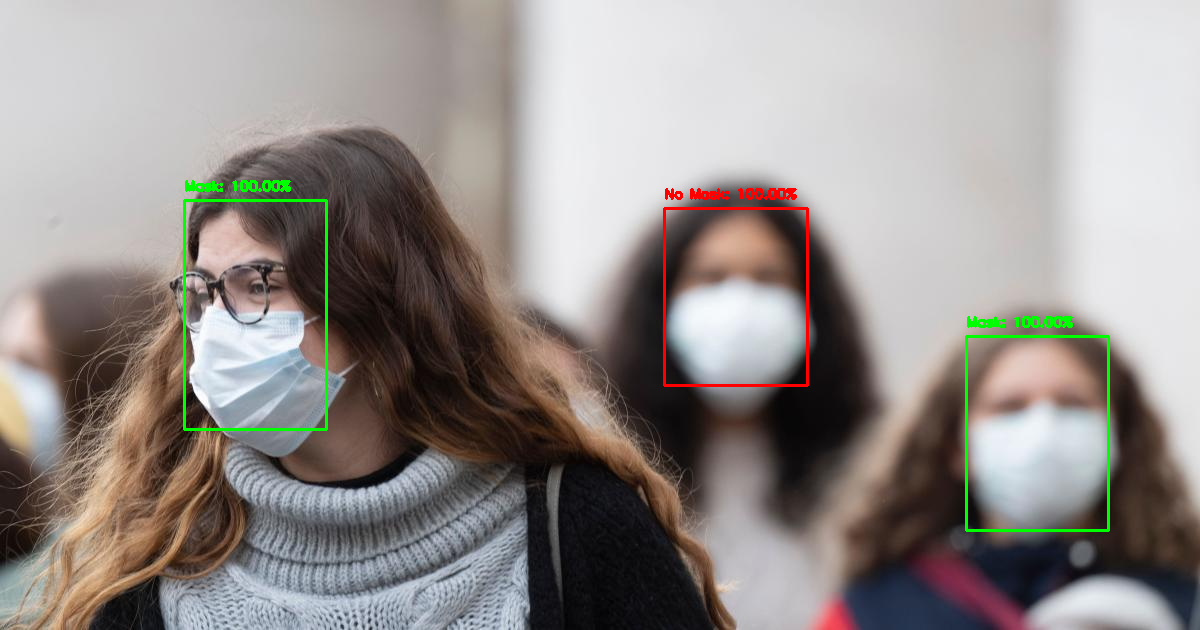

In [11]:
input_file_path = "/content/drive/My Drive/dataset/test/masked/with_mask434.jpg" 
#input_file_path_without_mask = "/content/drive/My Drive/dataset/test/unmasked/100.jpg"
print("[INFO] loading face detector model...")
prototxtPath = "/content/sample_data/deploy.prototxt"
weightsPath = "/content/sample_data/res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNet(prototxtPath, weightsPath)
# load the face mask detector
print("[INFO] loading face mask detector model...")
model = load_model("/content/covid_model_facemask.h5")
def process_images(input_file_path):
  image = cv2.imread(input_file_path)
  (h, w) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))
 # pass the blob through the network and obtain the face detections
  print("[INFO] computing face detections...")
  net.setInput(blob)
  detections = net.forward()
  for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.5:
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")
      (startX, startY) = (max(0, startX), max(0, startY))
      (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
      face = image[startY:endY, startX:endX]
      face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
      face = cv2.resize(face, (64, 64))
      face = img_to_array(face)
      face = preprocess_input(face)
      face = np.expand_dims(face, axis=0)
      (mask, withoutMask) = model.predict(face)[0]
      label = "Mask" if mask > withoutMask else "No Mask"
      color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
      cv2.putText(image, label, (startX, startY - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
  save_path = input_file_path.split(".",1)
  cv2_imshow(image)


process_images(input_file_path)